## SigNet

SigNet attribution across bins of repair efficiency.

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr,norm
from numpy import random,sqrt

In [2]:
import matplotlib
#matplotlib.use('PDF')
import matplotlib.pylab as plt
from matplotlib import rc
plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue']}, size=13)
plt.rcParams['pdf.fonttype'] = 42
figsize,width,mec = (2,2), 1, 'none'

In [3]:
from multiprocess import Pool,cpu_count
from tqdm import tqdm
def applyParallel(dfGrouped, func):
    with Pool(cpu_count()-2) as p:
        ret_list = list(tqdm(p.imap(func, dfGrouped),total=len(dfGrouped)))
    return pd.concat(ret_list)

In [4]:
from tools import Reference,COSMIC,A,C,G,T
ref = Reference(19)
cosmic = COSMIC()
from signaturesnet.modules.signet_module import SigNet
filename = os.path.expanduser('~/SigNet/signaturesnet/data/real_data/3mer_WG_hg37.txt')
signet = SigNet(opportunities_name_or_path=filename)
filename = os.path.expanduser('~/SigNet/signaturesnet/data/data.xlsx')
xlsx = pd.read_excel(filename, sheet_name=None)
signatures = xlsx['SBS_GRCh37'].columns[1:].to_numpy()
of_interest = np.array([0,4,3,6,7,8,9,11,15,19,22,23,44])
colors = ['crimson','gold','cyan','navy','navy','navy','navy',
          'pink','palegreen','limegreen','turquoise','purple','yellow']
print('Signatures of interest:', ' '.join(signatures[of_interest]))

Signatures of interest: SBS1 SBS5 SBS4 SBS7a SBS7b SBS7c SBS7d SBS9 SBS12 SBS16 SBS18 SBS19 SBS40


In [5]:
wsize = '5Mb'
window_size = int(5e6)
backgrounds = pd.read_table(f'../data/features2windows/{wsize}.background.tab.gz', sep="\t")
backgrounds['WindowIndex'] = backgrounds['Chr'] + '_' + (backgrounds['Start']//window_size).astype(int).astype(str)

filename = os.path.expanduser('~/SigNet/signaturesnet/data/real_data/3mer_WG_hg37.txt')
contextHist = pd.read_table(filename, header=None, names=['GeneralContext','Count'])
contextHist['Context'] = contextHist.apply(
    lambda x: cosmic.revContext(x['GeneralContext']) if x['GeneralContext'][1] in [A,G] else x['GeneralContext'], axis=1)
contextHist = contextHist.groupby('Context')['Count'].sum()
cosmic.cosmic['Context']=cosmic.cosmic.Type.str[0]+cosmic.cosmic.Type.str[2]+cosmic.cosmic.Type.str[6]
if 'Count' not in cosmic.cosmic.columns:
    cosmic.cosmic = cosmic.cosmic.merge(contextHist, left_on='Context', right_index=True, how='left')

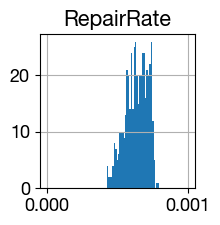

In [6]:
dat = pd.read_csv(f"../data/features2windows/{wsize}.merged.csv.gz", sep=",", na_values=".")
dat['Chr'] = dat.chrom
dat['Start'] = dat.start
dat['End'] = dat.end
dat['WindowIndex'] = dat['Chr'] + '_' + (dat['Start']//window_size).astype(int).astype(str)
dat = dat.merge(backgrounds[list(cosmic.order+['WindowIndex'])], on='WindowIndex', how='right')
dat.dropna(subset=cosmic.order, inplace=True)
dat.reset_index(drop=True, inplace=True)

dat.rename(columns={'cpd_repair': 'RepairRate'}, inplace=True)
dat[['RepairRate']].hist(bins=np.linspace(0,0.001,100),figsize=figsize)
plt.show()

In [9]:
percentiles_limits = dat['RepairRate'].quantile(np.linspace(0,1,101)).values
percentiles = pd.DataFrame(zip(percentiles_limits,percentiles_limits[1:]), columns=['Start','End'])
#assign percentile index to each row of dat
dat['RepairRatePercentile'] = pd.cut(dat['RepairRate'], bins=percentiles_limits, include_lowest=True,labels=False)

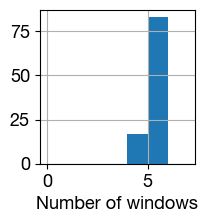

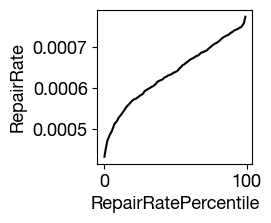

In [10]:
dat.groupby('RepairRatePercentile').size().hist(bins=range(0,8),figsize=figsize)
plt.xlabel('Number of windows')
plt.show()

dat.groupby('RepairRatePercentile')['RepairRate'].mean().plot(figsize=figsize, color='black')
plt.ylabel('RepairRate')
plt.show()

In [ ]:
dataset = 'Yoshida2020'
filename = '../data/{}/{}.csv.gz'.format(dataset, dataset)
df = pd.read_csv(filename)
filename = f'../data/{dataset}/{dataset}.tab.gz'
df_info = pd.read_table(filename)
dct = {'ex-smoker': 'smoker', 'non-smoker': 'never-smoker', 'smoker': 'smoker'}
df_info['Smoking'] = df_info.Status.map(dct)
df_info['Smoking'] = df_info.Tissue_CellType + '_' + df_info.Smoking
df['Tissue_CellType'] = df.Sample.map(dict(df_info[['Sample','Smoking']].values))
df = df.loc[df.Tissue_CellType=='Lung_smoker'].reset_index(drop=True)

df['Window'] = (df.Pos//window_size).astype(int)
df['WindowIndex'] = df.Chr + '_' + df.Window.astype(str)

df = df.merge(dat[['WindowIndex','RepairRatePercentile']], on='WindowIndex', how='left')
df = df.loc[df.RepairRatePercentile.notna()].reset_index(drop=True)

df.groupby('RepairRatePercentile').size().hist(bins=20,figsize=figsize)
plt.xlabel('Number of mutations')
plt.show()

Skip


In [13]:
backgroundsRepair = dat.groupby('RepairRatePercentile')[cosmic.order].sum().reset_index(drop=False)
backgroundsRepair[cosmic.order] = backgroundsRepair[cosmic.order].div(backgroundsRepair[cosmic.order].sum(axis=1), axis=0)

Signet inference

In [15]:
# signet format of the data
partition = ['RepairRatePercentile'] #partition = ['Sample']
mutations = df.groupby(['Type']+partition).size().unstack(level=0).fillna(0).astype(int)
mutations.reset_index(inplace=True,drop=False)

Z = 1./mutations[mutations.columns[1:]].sum(axis=1)
mutations_normalized = pd.DataFrame(np.einsum('ij,i->ij',mutations[mutations.columns[1:]],Z),index=mutations[mutations.columns[1:]].index,columns=mutations[mutations.columns[1:]].columns)
mutations_normalized['RepairRatePercentile'] = mutations['RepairRatePercentile']

mutations.sort_values(by=['RepairRatePercentile'], inplace=True)
#drop rows in backgroundsRepair and dat that are not in mutations
backgroundsRepair = backgroundsRepair.loc[backgroundsRepair['RepairRatePercentile'].isin(mutations['RepairRatePercentile'])].reset_index(drop=True)
dat = dat.loc[dat['RepairRatePercentile'].isin(mutations['RepairRatePercentile'])].reset_index(drop=True)
#sort backgroundsRepair by RepairRatePercentile
backgroundsRepair.sort_values(by=['RepairRatePercentile'], inplace=True)
cosmic_alphabet = cosmic.cosmic.sort_values(by=['Type'],inplace=False)
if (cosmic_alphabet.Type==mutations.columns[1:]).all(): print('OK')

OK


In [16]:
Z1 = mutations[mutations.columns[1:]].sum(axis=1)
normalized = mutations[mutations.columns[1:]]/backgroundsRepair[mutations.columns[1:]]
Z2 = cosmic_alphabet['Count'].values.astype(float)
normalized_properly = pd.DataFrame(np.einsum('ij,j->ij',normalized,Z2),index=normalized.index,columns=normalized.columns)
Z3 = normalized_properly.sum(axis=1)
Z = Z1/Z3
mutations_normalized = pd.DataFrame(np.einsum('ij,i->ij',normalized_properly,Z),index=mutations.index,columns=mutations[mutations.columns[1:]].columns)
mutations_normalized['RepairRatePercentile'] = mutations['RepairRatePercentile']

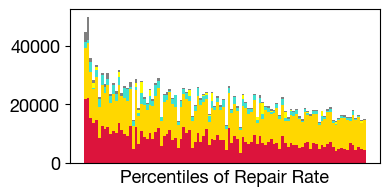

In [23]:
result = signet(mutation_dataset=mutations_normalized)
w, _, _, _, _ = result.get_output()
numbers = mutations[mutations.columns[1:]].sum(axis=1).values
order = np.argsort(-numbers)
order = np.argsort(dat.groupby('RepairRatePercentile')['RepairRate'].mean().values)
w2 = (w.T[of_interest]*numbers)[:,order]
w2residual = sum((w.T*numbers))[order]-sum(w2)
w2df = pd.DataFrame(w2.T,columns=[signatures[of_interest]])
w2df['Other'] = w2residual
samples = range(len(order))

plt.figure(figsize=(4,2))
for i,w2i in enumerate(w2): plt.bar(samples,w2i,bottom=sum(w2[:i]),color=colors[i],width=width) 
plt.bar(samples,w2residual,bottom=sum(w2),color='grey',width=width) 
plt.xlabel('Percentiles of Repair Rate')
plt.xticks([])
plt.ylim(ymin=0)
plt.show()

In [20]:
output = mutations.astype({'RepairRatePercentile': 'int'}).copy()
signs = pd.DataFrame(w, columns=list(signatures)+['other'])
values = mutations[mutations.columns[1:]].sum(axis=1).values 
numbers = signs*values[:,np.newaxis]
numbers.columns = ['n'+col for col in numbers.columns]
output = output.merge(signs, left_index=True, right_index=True)
output = output.merge(numbers, left_index=True, right_index=True)
output['RepairRate'] = dat.groupby('RepairRatePercentile')['RepairRate'].mean().values

In [ ]:
filename = '../data/Olafsson2020/Olafsson2020-signet-smokers-along-repair.tab'
#output.to_csv(filename, sep="\t", index=False)